- Initialization:
    - Importing libraries and setting up constants for simulation.
- RCS Dynamics:
    - Calculating torques generated by thrusters.
- Grid Fin Dynamics:
    - Calculating aerodynamic forces (lift and drag).
- Transition Logic:
    - Determining when to switch control modes between RCS and grid fins.
- Simulation Loop:
    - Time-stepped integration of dynamics, updating altitude, velocity, and control states.
- Visualization:
    - Plotting altitude, torque, and angular velocity against time for analysis.

In [87]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Constants
TIME_STEPS = 5000  # Increased number of time steps for more samples
DT = 0.1  # Time step duration in seconds
ALTITUDE_START = 40000  # Initial altitude in meters
TARGET_ALTITUDE = 0  # Target altitude
AIR_DENSITY_SEA_LEVEL = 1.225  # Air density (kg/m^3)
FIN_AREA = 0.1  # Grid fin area (m^2)
PERTURBATION_INTERVAL = 100  # Apply perturbation every 100 steps
PERTURBATION_MAGNITUDE = 0.05  # Magnitude of perturbation

# Initial Conditions
altitude = ALTITUDE_START
velocity = 50  # Descent velocity (m/s)
angular_velocity = np.zeros(3, dtype=float)
fuel_used = 0  # Initialize fuel consumption
torque = np.zeros(3, dtype=float)

# State History
state_history = {
    "altitude": [],
    "control_mode": [],
    "fuel": [],
    "angular_velocity": [],
    "torque": [],
    "perturbation": [],
    "sideways_deviation": []
}

# Control Mode Selector
def control_mode_selector(altitude):
    """Select control mode based on altitude."""
    if altitude > 30000:
        return "RCS"
    elif altitude > 10000:
        return "Hybrid"
    else:
        return "Grid Fins"

# RCS Torque
def rcs_torque(thruster_positions, thrust_forces):
    """Calculate torque from RCS thrusters."""
    return np.sum([np.cross(pos, force) for pos, force in zip(thruster_positions, thrust_forces)], axis=0)

# Grid Fin Aerodynamics
def aerodynamic_forces(velocity, angle_of_attack, air_density, fin_area):
    """Calculate lift and drag forces for Grid Fins."""
    lift = 0.5 * air_density * velocity**2 * fin_area * np.sin(np.radians(angle_of_attack))
    drag = 0.5 * air_density * velocity**2 * fin_area * np.cos(np.radians(angle_of_attack))
    return lift, drag

# Hybrid Torque
def hybrid_control(rcs_torque, grid_torque, altitude):
    """Combine RCS and Grid Fin torques."""
    weight_rcs = max(0, (altitude - 10000) / 20000)
    weight_grid = 1 - weight_rcs
    return weight_rcs * rcs_torque + weight_grid * grid_torque

# PID Controller
class PIDController:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.previous_error = 0
        self.integral = 0

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.previous_error) / dt
        self.previous_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative

# PID Instance
roll_pid = PIDController(kp=0.1, ki=0.01, kd=0.05)


In [88]:
# Simulation Loop
for step in range(TIME_STEPS):
    # Record current state
    state_history["altitude"].append(altitude)
    mode = control_mode_selector(altitude)
    state_history["control_mode"].append(mode)

    # Initialize torque
    torque = np.zeros(3, dtype=float)

    # Apply control based on mode
    if mode == "RCS":
        thruster_positions = np.array([[1, 0, 0], [-1, 0, 0]])
        thrust_forces = np.array([[0, 0, 10], [0, 0, 10]], dtype=float)
        torque = rcs_torque(thruster_positions, thrust_forces)
        fuel_used += np.sum(np.linalg.norm(thrust_forces, axis=1)) * DT
    elif mode == "Grid Fins":
        air_density = AIR_DENSITY_SEA_LEVEL * max(altitude / ALTITUDE_START, 0)
        lift, drag = aerodynamic_forces(velocity, 10, air_density, FIN_AREA)
        torque = np.array([lift, drag, 0], dtype=float)
    else:  # Hybrid Mode
        thruster_positions = np.array([[1, 0, 0], [-1, 0, 0]])
        thrust_forces = np.array([[0, 0, 5], [0, 0, 5]], dtype=float)
        rcs_t = rcs_torque(thruster_positions, thrust_forces)
        air_density = AIR_DENSITY_SEA_LEVEL * max(altitude / ALTITUDE_START, 0)
        lift, drag = aerodynamic_forces(velocity, 10, air_density, FIN_AREA)
        grid_torque = np.array([lift, drag, 0], dtype=float)
        torque = hybrid_control(rcs_t, grid_torque, altitude)
        fuel_used += 0.5 * np.sum(np.linalg.norm(thrust_forces, axis=1)) * DT

    # Apply PID correction
    roll_error = altitude - TARGET_ALTITUDE
    roll_correction = roll_pid.compute(roll_error, DT)
    torque += np.array([roll_correction, 0, 0], dtype=float)

    # Introduce perturbations
    if step % PERTURBATION_INTERVAL == 0:
        perturbation = PERTURBATION_MAGNITUDE * np.random.randn(3)
    else:
        perturbation = np.zeros(3)
    angular_velocity += perturbation
    state_history["perturbation"].append(perturbation)

    # Record lateral deviation (ensure consistent updates)
    sideways_deviation = np.linalg.norm(perturbation[:2])  # Lateral components of perturbation
    state_history["sideways_deviation"].append(sideways_deviation)

    # Update dynamics
    angular_velocity += torque * DT
    altitude = max(altitude - velocity * DT, 0)

    # Record fuel and torque
    state_history["fuel"].append(fuel_used)
    state_history["torque"].append(np.linalg.norm(torque))

    # Stop simulation if altitude reaches zero
    if altitude == 0:
        break

print("Simulation Complete")
print(f"Final Altitude: {altitude} meters")
print(f"Total Fuel Used: {fuel_used:.2f} units")


Simulation Complete
Final Altitude: 15000.0 meters
Total Fuel Used: 5500.00 units


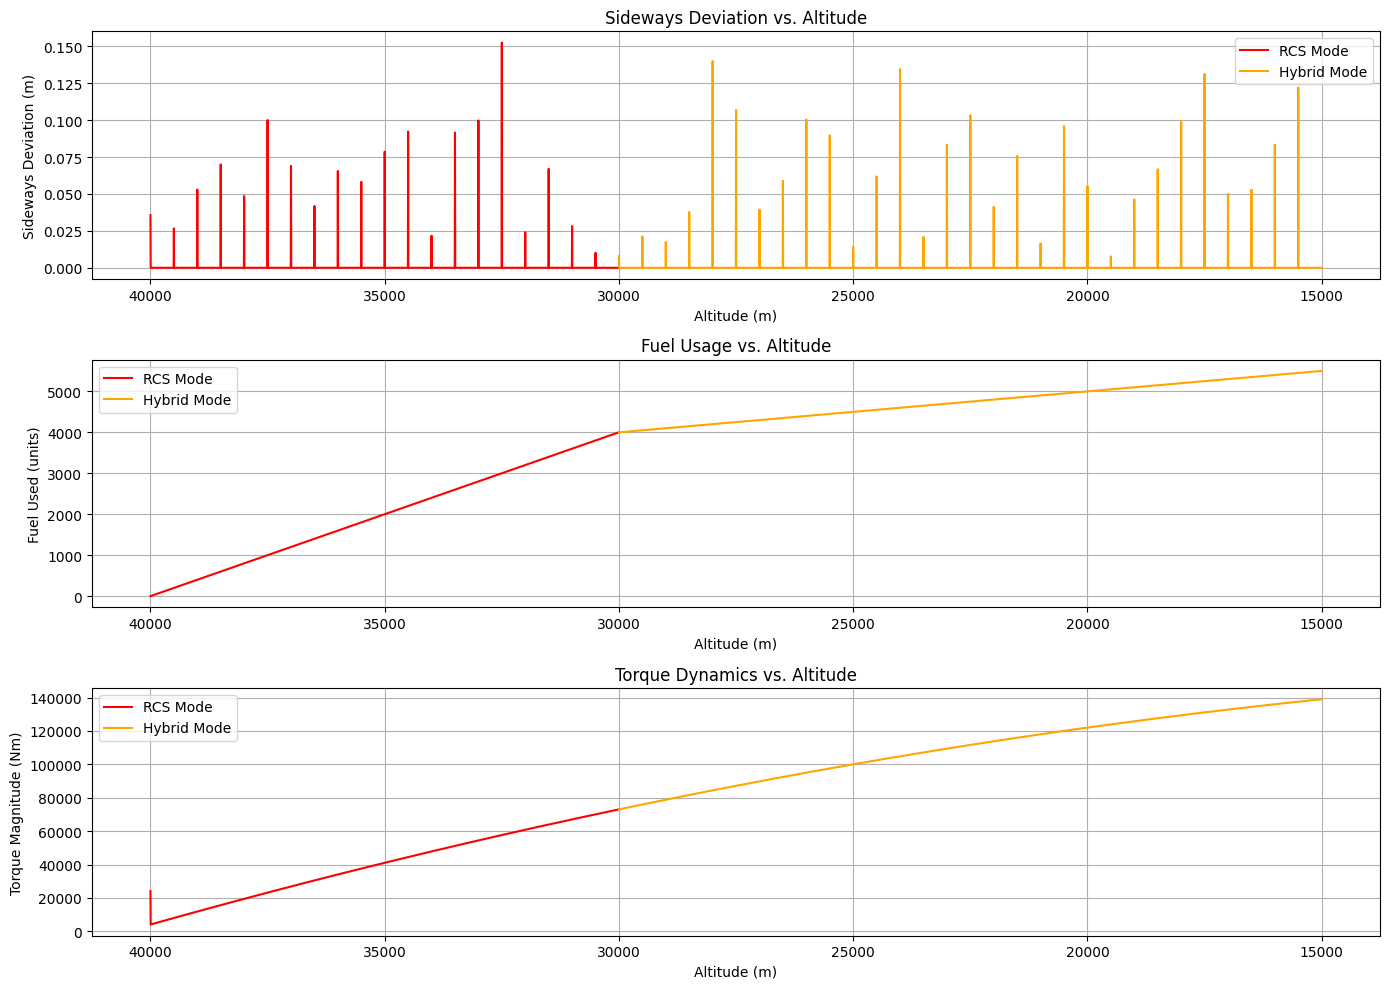

In [89]:
# Enhanced Visualization: Compare Metrics Across Modes

# Extract data
altitudes = np.array(state_history["altitude"])
sideways_deviation = np.array(state_history["sideways_deviation"])
fuel = np.array(state_history["fuel"])
torque = np.array(state_history["torque"])
control_modes = np.array(state_history["control_mode"])

# Define colors for each mode
mode_colors = {'RCS': 'red', 'Hybrid': 'orange', 'Grid Fins': 'green'}
mode_indices = {mode: np.where(control_modes == mode)[0] for mode in mode_colors}

# Plot sideways deviation for each mode
plt.figure(figsize=(14, 10))

# Subplot 1: Sideways Deviation
plt.subplot(3, 1, 1)
for mode, indices in mode_indices.items():
    if len(indices) > 0:
        plt.plot(
            altitudes[indices], sideways_deviation[indices],
            label=f"{mode} Mode", color=mode_colors[mode], linewidth=1.5
        )
plt.title("Sideways Deviation vs. Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Sideways Deviation (m)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid()

# Subplot 2: Fuel Usage
plt.subplot(3, 1, 2)
for mode, indices in mode_indices.items():
    if len(indices) > 0:
        plt.plot(
            altitudes[indices], fuel[indices],
            label=f"{mode} Mode", color=mode_colors[mode], linewidth=1.5
        )
plt.title("Fuel Usage vs. Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Fuel Used (units)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid()

# Subplot 3: Torque Dynamics
plt.subplot(3, 1, 3)
for mode, indices in mode_indices.items():
    if len(indices) > 0:
        plt.plot(
            altitudes[indices], torque[indices],
            label=f"{mode} Mode", color=mode_colors[mode], linewidth=1.5
        )
plt.title("Torque Dynamics vs. Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Torque Magnitude (Nm)")
plt.gca().invert_xaxis()
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
